In [11]:
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.cm as cm
import matplotlib.dates as mdates


In [12]:
row_accumulator = []
for filename in glob.glob('../../Data/NVD/nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'BaseScore': base_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-02-01') & (nvd['Published']  < '2026-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['Assigner'] = nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org')

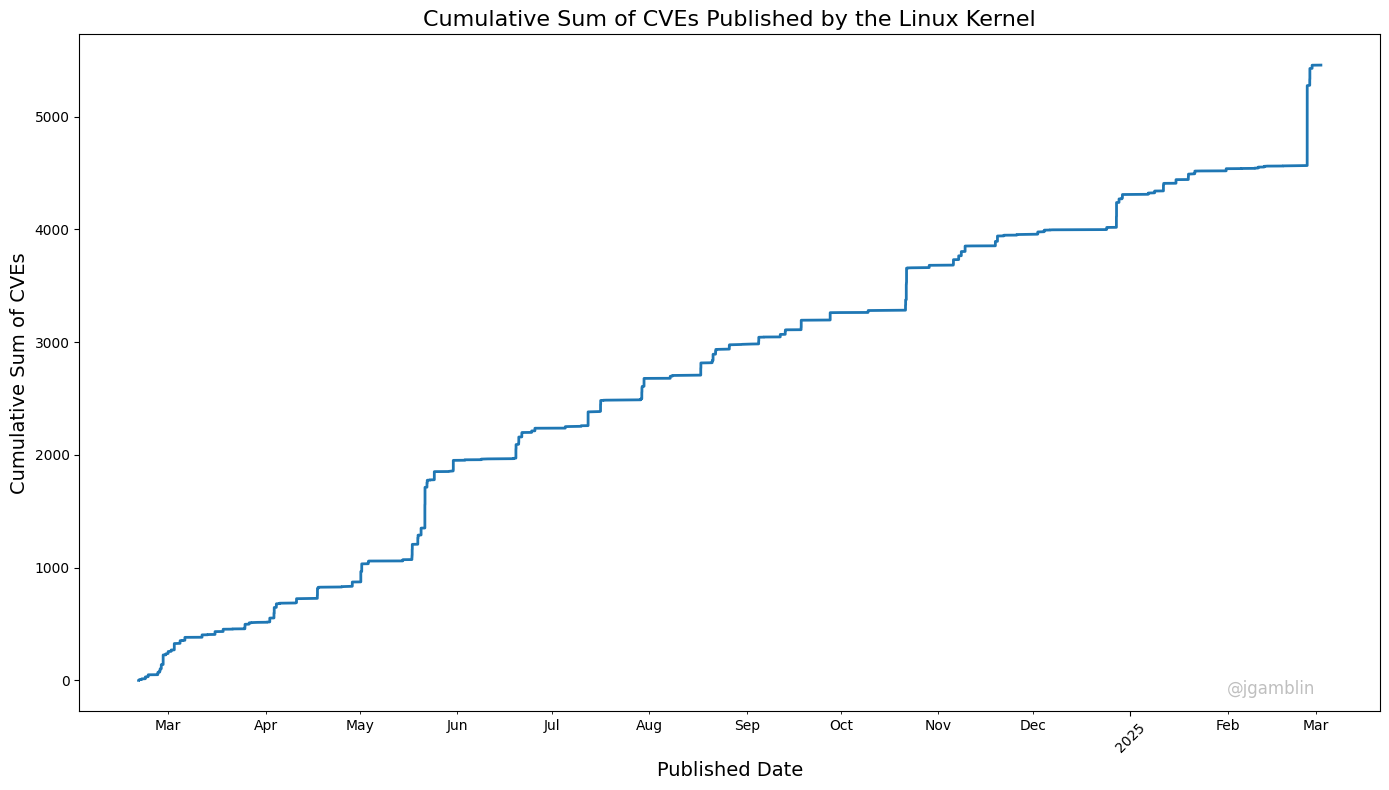

In [13]:
# Change the 'Assigner' column to 'CNA' and process the email to extract the domain, remove the TLD, and capitalize the word
def extract_cna(email):
    try:
        domain = email.split('@')[1].split('.')[0]
        return domain.capitalize()
    except IndexError:
        return 'Unknown'

nvd['CNA'] = nvd['Assigner'].apply(extract_cna)

# Filter the data for the CNA named 'Kernel'
kernel_data = nvd[nvd['CNA'] == 'Kernel']

# Calculate the cumulative sum of CVEs for the CNA named 'Kernel'
# Make an explicit copy of the DataFrame slice
kernel_data = kernel_data.copy()

# Convert the 'Published' column to datetime and assign it to 'published_date'
kernel_data['published_date'] = pd.to_datetime(kernel_data['Published'])
kernel_data = kernel_data.sort_values('published_date')
kernel_data['cumulative_count'] = kernel_data.groupby('CNA').cumcount() + 1

# Plot the cumulative sum of CVEs for the CNA named 'Kernel'
plt.figure(figsize=(14, 8))
plt.plot(kernel_data['published_date'], kernel_data['cumulative_count'], label='Kernel', linewidth=2)

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Add labels, title, legend, and grid
plt.xlabel('Published Date', fontsize=14)
plt.ylabel('Cumulative Sum of CVEs', fontsize=14)
plt.title('Cumulative Sum of CVEs Published by the Linux Kernel', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

# Add watermark
plt.text(0.95, 0.02, '@jgamblin', fontsize=12, color='grey', ha='right', va='bottom', transform=plt.gca().transAxes, alpha=0.5)


# Save the plot as a large PNG file
plt.savefig('cumulative_cves_kernel.png', dpi=300)

# Show the plot
plt.show()

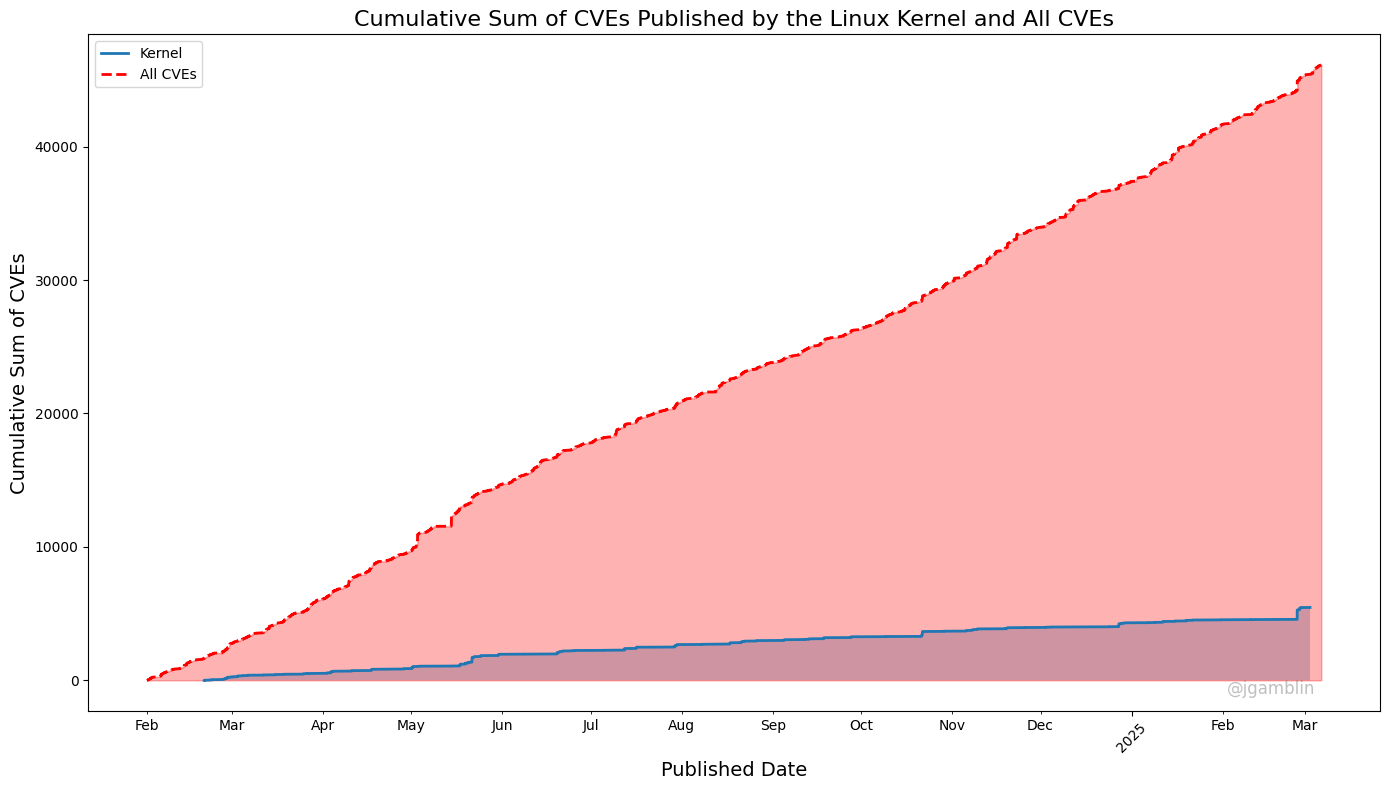

In [14]:
# Filter the data for the CNA named 'Kernel'
kernel_data = nvd[nvd['CNA'] == 'Kernel']

# Calculate the cumulative sum of CVEs for the CNA named 'Kernel'
# Make an explicit copy of the DataFrame slice
kernel_data = kernel_data.copy()

# Convert the 'Published' column to datetime and assign it to 'published_date'
kernel_data['published_date'] = pd.to_datetime(kernel_data['Published'])
kernel_data = kernel_data.sort_values('published_date')
kernel_data['cumulative_count'] = kernel_data.groupby('CNA').cumcount() + 1

# Calculate the cumulative sum of all CVEs
nvd['published_date'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values('published_date')
nvd['cumulative_all'] = nvd.index + 1  # Use the index to get the cumulative count

# Plot the cumulative sum of CVEs for the CNA named 'Kernel'
plt.figure(figsize=(14, 8))
plt.plot(kernel_data['published_date'], kernel_data['cumulative_count'], label='Kernel', linewidth=2)
plt.fill_between(kernel_data['published_date'], kernel_data['cumulative_count'], alpha=0.3)

# Plot the cumulative sum of all CVEs
plt.plot(nvd['published_date'], nvd['cumulative_all'], label='All CVEs', linewidth=2, linestyle='--', color='red')
plt.fill_between(nvd['published_date'], nvd['cumulative_all'], alpha=0.3, color='red')

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Add labels, title, legend, and grid
plt.xlabel('Published Date', fontsize=14)
plt.ylabel('Cumulative Sum of CVEs', fontsize=14)
plt.title('Cumulative Sum of CVEs Published by the Linux Kernel and All CVEs', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Add watermark
plt.text(0.95, 0.02, '@jgamblin', fontsize=12, color='grey', ha='right', va='bottom', transform=plt.gca().transAxes, alpha=0.5)

# Save the plot as a large PNG file
plt.savefig('cumulative_cves_kernel_and_all.png', dpi=300)

# Show the plot
plt.show()

In [15]:
# Assuming kernel_data is your DataFrame and 'Published' column is already in datetime format
# Filter for Linux CNA entries
linux_cna_data = kernel_data[kernel_data['Assigner'] == 'cve@kernel.org']

# Ensure 'Published' column is in datetime format
linux_cna_data['Published'] = pd.to_datetime(linux_cna_data['Published'])

# Group by publishing date and count occurrences
publishing_counts = linux_cna_data['Published'].dt.date.value_counts()

# Get the top 10 publishing days
top_10_publishing_days = publishing_counts.head(10)

# Convert to DataFrame for better display
top_10_publishing_days_df = top_10_publishing_days.reset_index()
top_10_publishing_days_df.columns = ['Publishing Date', 'Count']

# Display the table
top_10_publishing_days_df

,Publishing Date,Count
0,2025-02-26,711
1,2024-10-21,375
2,2024-05-21,362
3,2024-12-27,221
4,2025-02-27,180
5,2024-05-01,161
6,2024-05-17,136
7,2024-07-12,123
8,2024-06-19,122
9,2024-07-29,121


In [16]:
# Calculate the percentage of each column that contains 'Missing_Data' or 0.0
missing_or_zero_percentage = ((kernel_data == 'Missing_Data') | (kernel_data == 0.0)).mean() * 100

# Calculate the percentage of data present
data_present_percentage = 100 - missing_or_zero_percentage

# Convert the results to a DataFrame
linux_df = pd.DataFrame({
    'Column': missing_or_zero_percentage.index,
    'Linux CNA Data Present': data_present_percentage.values
})

# Format 'Linux CNA Data Present' to show up to two decimal places, but only if necessary
linux_df['Linux CNA Data Present'] = linux_df['Linux CNA Data Present'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))

# Calculate the percentage of each column that contains 'Missing_Data' or 0.0
missing_or_zero_percentage = ((nvd == 'Missing_Data') | (nvd == 0.0)).mean() * 100

# Calculate the percentage of data present
data_present_percentage = 100 - missing_or_zero_percentage

# Convert the results to a DataFrame
nvd_df = pd.DataFrame({
    'Column': missing_or_zero_percentage.index,
    'NVD Data Present': data_present_percentage.values
})

# Format 'NVD Data Present' to show up to two decimal places, but only if necessary
nvd_df['NVD Data Present'] = nvd_df['NVD Data Present'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))


In [18]:
import pandas as pd

# Combine linux_df and nvd_df into a single DataFrame
combined_df = pd.merge(linux_df, nvd_df, on='Column', how='outer')

# Drop the specified rows
rows_to_drop = ['cumulative_all', 'cumulative_count', 'published_date']
combined_df = combined_df[~combined_df['Column'].isin(rows_to_drop)]

# Switch the order of the columns
combined_df = combined_df[['Column', 'NVD Data Present', 'Linux CNA Data Present']]

# Calculate the difference between 'Linux CNA Data Present' and 'NVD Data Present'
combined_df['Difference'] = combined_df['Linux CNA Data Present'].astype(float) - combined_df['NVD Data Present'].astype(float)

# Sort the DataFrame by the 'Difference' column
combined_df = combined_df.sort_values(by='Difference', ascending=False)

# Display the combined DataFrame
combined_df

,Column,NVD Data Present,Linux CNA Data Present,Difference
0,Assigner,100,100,0.00
2,CNA,100,100,0.00
3,CVE,100,100,0.00
5,Description,100,100,0.00
6,Published,100,100,0.00
7,Status,100,100,0.00
1,BaseScore,90.29,64.46,-25.83
4,CWE,90.68,60.83,-29.85
